In [1]:
import os
import sys
sys.path.append('../')
import shutil
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import transforms
from torchvision import datasets

import cv2
from google.colab.patches import cv2_imshow


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from skimage.metrics import structural_similarity
!pip install phasepack
import phasepack.phasecong as pc

# evaluate_model.DEVICE = device
SR_FACTOR = 3
SIGMA = 1.0

  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26983 sha256=dc315036845cfa2ba172b934bbc89170580ce6e7dd21212b24d95622329e6236
  Stored in directory: /root/.cache/pip/wheels/39/5c/b3/79292d7ac3f088e858805b5515b45cf5a365106397d936caf1
Successfully built phasepack


/usr/local/lib/python3.7/dist-packages/phasepack/tools.py:14: UserWarning: 
Module 'pyfftw' (FFTW Python bindings) could not be imported. To install it, try
running 'pip install pyfftw' from the terminal. Falling back on the slower
'fftpack' module for 2D Fourier transforms.
  'fftpack' module for 2D Fourier transforms.""")


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
"""
   Functions of general utility that are used throughout the project.
"""


def ycbcr2rgb(im):
    """
        Takes images in YCbCr format and converts it to RGB
        Args:
            im (np.ndarray): image in YCbCr format
        Returns:
            rgb (np.ndarray): im in rgb format
        source: https://stackoverflow.com/questions/34913005/color-space-mapping-ycbcr-to-rgb
    """
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:, :, [1, 2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)


def psnr(img1, img2):
    """
        Calculate the Peak Signal to Noise Ratio between two images.
        formula: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
        Args:
            img1 (np.ndarray): image of any number of channels
            img2 (np.ndarray): image of any number of channels
        Returns:
            psnr (float): psnr between img1 and img2 in dB
    """
    mse = np.mean(np.power(img1.astype(np.double) - img2.astype(np.double), 2))
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    p_snr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return p_snr

In [ ]:
"""
    Functions used for distorting images for training
"""


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def distort_image(path, factor, sigma=1, blur=True):
    """ Distorts image by bluring it, decreasing its resolution
        by some factor, then increasing resolution - by bicubic
        interpolation.
        Args:
            path (string): absolute path to an image file
            factor (int): the resolution factor for interpolation
            sigma (float): the std. dev. to use for the gaussian blur
            blur (boolean): if True, gaussian blur is performed on im
        Returns:
            blurred_img (numpy.ndarray): distorted image in YCbCr with
                type uint8
    """
    image_file = cv2.imread(path)
    image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2YCR_CB)
    im = np.array(image_file)
    im_Y, im_Cb, im_Cr = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    im_Y = (im_Y.astype(np.int16)).astype(np.float32)
    im_Cb = (im_Cb.astype(np.int16)).astype(np.float32)
    im_Cr = (im_Cr.astype(np.int16)).astype(np.float32)
    if blur:
        im_Y_blurred = cv2.GaussianBlur(im_Y, (3, 3), sigma)
    else:
        im_Y_blurred = im_Y
    im_blurred = np.copy(im)
    im_blurred[:, :, 0] = im_Y_blurred
    im_blurred[:, :, 1] = im_Cb
    im_blurred[:, :, 2] = im_Cr
    width, length = im_Y.shape
    im_blurred = Image.fromarray(im_blurred, mode='YCbCr')
    im_blurred = im_blurred.resize(size=(int(length/factor),
                                         int(width/factor)),
                                   resample=Image.BICUBIC)

    im_blurred = im_blurred.resize(size=(length, width),
                                   resample=Image.BICUBIC)
    im_blurred = np.array(im_blurred.convert('YCbCr'))
    return im_blurred

In [ ]:
def display_image(path):
  image_file = Image.open(path)
  im = np.array(image_file)
  im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
  cv2_imshow(im)
  return None

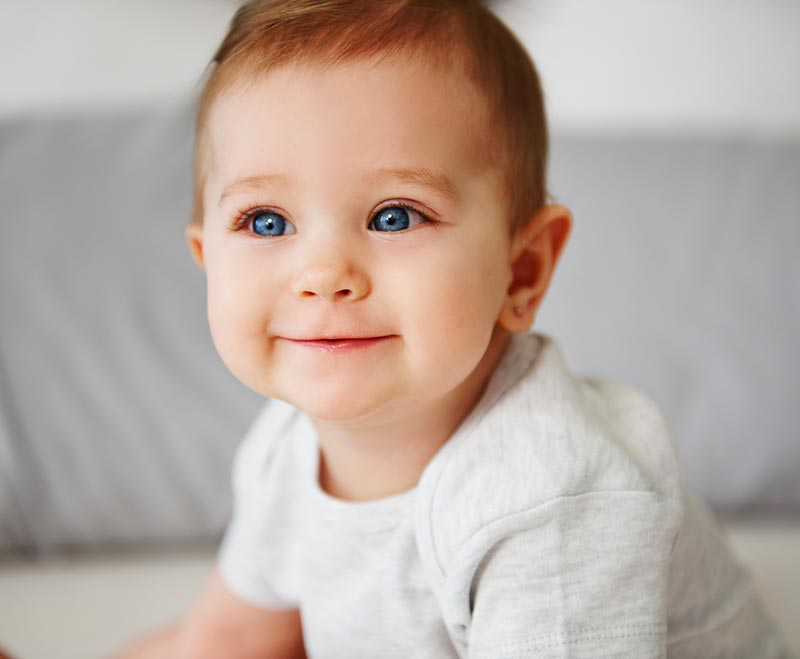

In [ ]:
display_image('/content/gdrive/MyDrive/mytestset/baby.jpg')

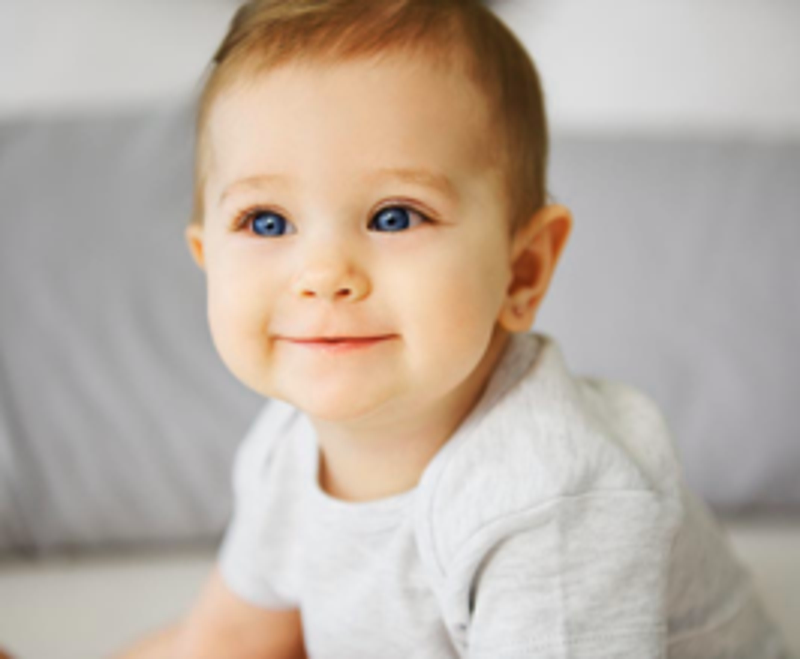

In [ ]:
a = cv2.imread('/content/gdrive/MyDrive/mytestset/baby.jpg')
b = distort_image('/content/gdrive/MyDrive/mytestset/baby.jpg', 3)


cv2_imshow(ycbcr2rgb(b))

x = fsim(cv2.cvtColor(a, cv2.COLOR_BGR2RGB), ycbcr2rgb(b))

In [ ]:
x

0.7338329085837393

In [ ]:
from skimage.measure import compare_ssim
def ssim_metric(img1, img2):
  g1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
  g2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
  (score, diff) = compare_ssim(g1, g2, full=True)
  diff = (diff * 255).astype("uint8")
  return score

In [ ]:
def _assert_image_shapes_equal(org_img: np.ndarray, pred_img: np.ndarray, metric: str):
    msg = (f"Cannot calculate {metric}. Input shapes not identical. y_true shape =sy_pred shape = {str(pred_img.shape)}")

    assert org_img.shape == pred_img.shape, msgtr(org_img.shape)

def _gradient_magnitude(img: np.ndarray, img_depth):
    """
    Calculate gradient magnitude based on Scharr operator
    """
    scharrx = cv2.Scharr(img, img_depth, 1, 0)
    scharry = cv2.Scharr(img, img_depth, 0, 1)

    return np.sqrt(scharrx ** 2 + scharry ** 2)

def _similarity_measure(x, y, constant):
    """
    Calculate feature similarity measurement between two images
    """
    numerator = 2 * x * y + constant
    denominator = x ** 2 + y ** 2 + constant

    return numerator / denominator

def fsim(org_img: np.ndarray, pred_img: np.ndarray, T1=0.85, T2=160) -> float:
        _assert_image_shapes_equal(org_img, pred_img, "FSIM")

        alpha = beta = 1  # parameters used to adjust the relative importance of PC and GM features
        fsim_list = []
        for i in range(org_img.shape[2]):
        # Calculate the PC for original and predicted images
            pc1_2dim = pc(org_img[:, :, i], nscale=4, minWaveLength=6, mult=2, sigmaOnf=0.5978)
            pc2_2dim = pc(pred_img[:, :, i], nscale=4, minWaveLength=6, mult=2, sigmaOnf=0.5978)

        # pc1_2dim and pc2_2dim are tuples with the length 7, we only need the 4th element which is the PC.
        # The PC itself is a list with the size of 6 (number of orientation). Therefore, we need to
        # calculate the sum of all these 6 arrays.
            pc1_2dim_sum = np.zeros((org_img.shape[0], org_img.shape[1]), dtype=np.float64)
            pc2_2dim_sum = np.zeros((pred_img.shape[0], pred_img.shape[1]), dtype=np.float64)
            for orientation in range(6):
                pc1_2dim_sum += pc1_2dim[4][orientation]
                pc2_2dim_sum += pc2_2dim[4][orientation]

        # Calculate GM for original and predicted images based on Scharr operator
            gm1 = _gradient_magnitude(org_img[:, :, i], cv2.CV_16U)
            gm2 = _gradient_magnitude(pred_img[:, :, i], cv2.CV_16U)

        # Calculate similarity measure for PC1 and PC2
            S_pc = _similarity_measure(pc1_2dim_sum, pc2_2dim_sum, T1)
        # Calculate similarity measure for GM1 and GM2
            S_g = _similarity_measure(gm1, gm2, T2)

            S_l = (S_pc ** alpha) * (S_g ** beta)

            numerator = np.sum(S_l * np.maximum(pc1_2dim_sum, pc2_2dim_sum))
            denominator = np.sum(np.maximum(pc1_2dim_sum, pc2_2dim_sum))
            fsim_list.append(numerator / denominator)

        return np.mean(fsim_list)

In [ ]:
"""
    Functions for evaluating model performance.
"""

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(path, model, pixel_mean, pixel_std, SR_FACTOR=3, sigma=1):
    """
        Computes average Peak Signal to Noise Ratio over a set of images and
        the versions super resolved by a srcnn or variant.
        Args:
            path (string): relative path to directory containing images for evaluation
            model (PyTorch model): the model to be evaluated
            pixel_mean (float): mean luminance value to be used for standardization
            pixel_std (float): std. dev. of luminance value to be used for standardization
            SR_FACTOR (int): super resolution factor
            sigma (int): the std. dev. to use for the gaussian blur
    """

    img_names = [im for im in os.listdir(path) if im[-4:] == '.bmp' or im[-4:] == '.jpg']
    blurred_img_psnr = []
    blurred_img_ssim = []
    blurred_img_fsim = []
    out_img_psnr = []
    out_img_ssim = []
    out_img_fsim = []
    for i, test_im in enumerate(img_names):

        blurred_test_im = distort_image(path=path+test_im, factor=SR_FACTOR, sigma=sigma)
        ImageFile = cv2.imread(path+test_im)
        ImageFile_Y = cv2.cvtColor(ImageFile, cv2.COLOR_BGR2YCR_CB)

        im = np.array(ImageFile_Y)

        #normalize
        model_input = blurred_test_im[:, :, 0] / 255.0
        #standardize
        model_input -= pixel_mean
        model_input /= pixel_std

        im_out_Y = model(torch.tensor(model_input,
                                      dtype=torch.float).unsqueeze(0).unsqueeze(0).to(DEVICE))
        im_out_Y = im_out_Y.detach().squeeze().squeeze().cpu().numpy().astype(np.float64)
        im_out_viz = np.zeros((im_out_Y.shape[0], im_out_Y.shape[1], 3))

        #unstandardize
        im_out_Y = (im_out_Y * pixel_std) + pixel_mean

        #un-normalize
        im_out_Y *= 255.0

        im_out_viz[:, :, 0] = im_out_Y
        im_out_viz[:, :, 1] = im[:, :, 1]
        im_out_viz[:, :, 2] = im[:, :, 2]

        im_out_viz[:, :, 0] = np.around(im_out_viz[:, :, 0])
        #psnr on Y only
        blur_psnr = psnr(im[:, :, 0], blurred_test_im[:, :, 0])
        blur_ssim = ssim_metric(cv2.cvtColor(ImageFile, cv2.COLOR_BGR2RGB), ycbcr2rgb(blurred_test_im))
        blur_fsim = fsim(cv2.cvtColor(ImageFile, cv2.COLOR_BGR2RGB), ycbcr2rgb(blurred_test_im))
        sr_psnr = psnr(im[:, :, 0], im_out_viz[:, :, 0])
        sr_ssim = ssim_metric(cv2.cvtColor(ImageFile, cv2.COLOR_BGR2RGB), ycbcr2rgb(im_out_viz))
        sr_fsim = fsim(cv2.cvtColor(ImageFile, cv2.COLOR_BGR2RGB), ycbcr2rgb(im_out_viz))

        print(f'The bicubic psnr of {i + 1} image is {blur_psnr}. The blur ssim is {blur_ssim} and the blur fsim is {blur_fsim}')
        print('\n')
        print(f'The sr psnr of {i + 1} image is {sr_psnr}. The blur ssim is {sr_ssim} and the blur fsim is {sr_fsim}')

        blurred_img_psnr.append(blur_psnr)
        blurred_img_ssim.append(blur_ssim)
        blurred_img_fsim.append(blur_fsim)
        out_img_psnr.append(sr_psnr)
        out_img_ssim.append(sr_ssim)
        out_img_fsim.append(sr_fsim)
        

    mean_blur_psnr = np.mean(np.array(blurred_img_psnrs))
    mean_sr_psnr = np.mean(np.array(out_img_psnrs))
    return mean_blur_psnr, mean_sr_psnr

In [ ]:
evaluate_model.DEVICE = device

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from urllib.request import urlretrieve

In [ ]:
if not os.path.isfile('BSR_bsds500.tgz'):
    urlretrieve('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz','BSR_bsds500.tgz')
if not os.path.isfile('content/BSR_bsds500.tgz'):
    !apt-get install p7zip-full
    !p7zip -d BSR_bsds500.tgz
    !tar -xvf BSR_bsds500.tgz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/bin/p7zip: BSR_bsds500.tgz: unknown suffix
BSR/
BSR/documentation/
BSR/documentation/Arbelaez_Maire_Fowlkes_Malik_TPAMI2010.pdf
BSR/bench/
BSR/bench/source/
BSR/bench/source/match.hh
BSR/bench/source/Matrix.cc
BSR/bench/source/Timer.cc
BSR/bench/source/csa_types.h
BSR/bench/source/csa.cc
BSR/bench/source/correspondPixels.cc
BSR/bench/source/build.sh
BSR/bench/source/match.cc
BSR/bench/source/Sort.hh
BSR/bench/source/csa_defs.h
BSR/bench/source/Timer.hh
BSR/bench/source/Exception.cc
BSR/bench/source/String.cc
BSR/bench/source/Array.hh
BSR/bench/source/kofn.hh
BSR/bench/source/Random.hh
BSR/bench/source/Exception.hh
BSR/bench/source/.gitignore
BSR/bench/source/kofn.cc
BSR/bench/source/build.m
BSR/bench/source/Random.cc
BSR/bench/source/Point.hh
BSR/bench/source/README
B

In [ ]:
training_img_names = [i for i in os.listdir('/content/BSR/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_gt_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('/content/BSR/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

training_img_names = [i for i in os.listdir('/content/BSR/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('/content/BSR/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:, :, 0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

            

In [ ]:
# prep target training images to be part of dataset

training_images_gt_patches = np.array(training_images_gt_patches)
print(training_images_gt_patches.shape)

#normalize
training_images_gt_patches /= 255.0

train_pixel_mean = np.mean(training_images_gt_patches)
print(train_pixel_mean)
train_pixel_std = np.std(training_images_gt_patches)
print(train_pixel_std)
#standardize
training_images_gt_patches -= train_pixel_mean
training_images_gt_patches /= train_pixel_std

training_images_gt_patches = torch.tensor(training_images_gt_patches)

(211600, 32, 32)
0.43411854967057834
0.2324727472279154


In [ ]:
aph = []

In [ ]:
# generate distorted images for training, using train and test of BSDS500
training_img_names = [i for i in os.listdir('/content/BSR/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_training_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('/content/BSR/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='/content/BSR/BSDS500/data/images/train/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)

training_img_names = [i for i in os.listdir('/content/BSR/BSDS500/data/images/test') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('/content/BSR/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='/content/BSR/BSDS500/data/images/test/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)

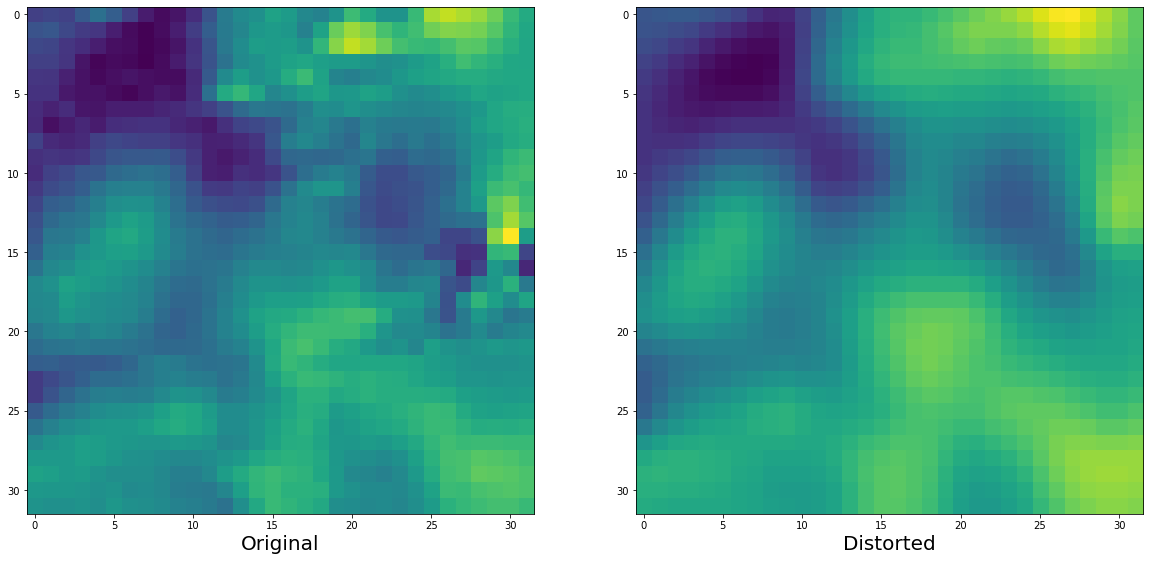

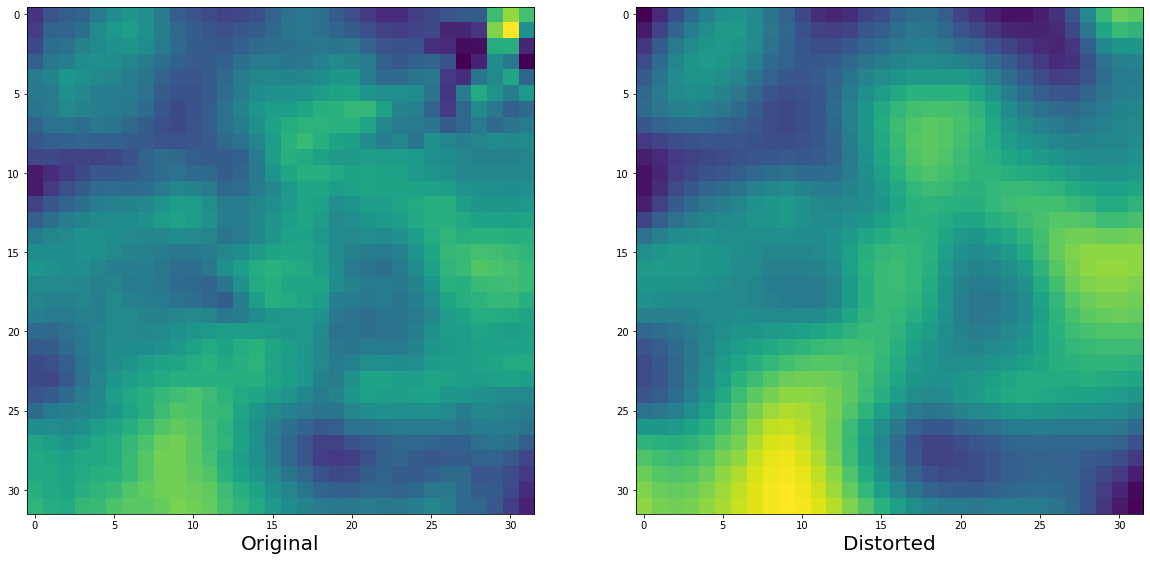

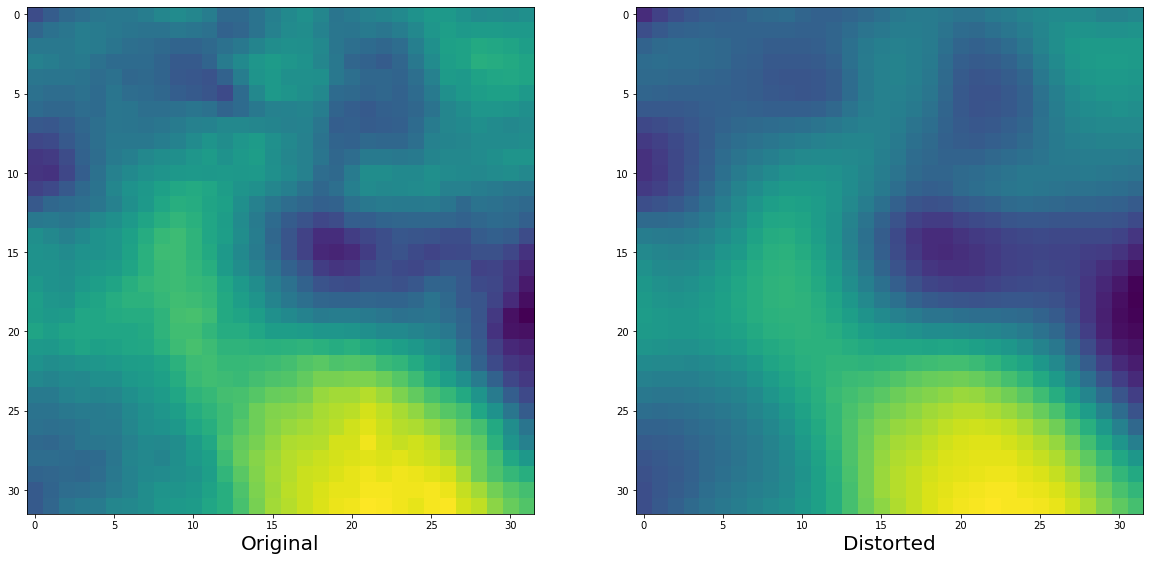

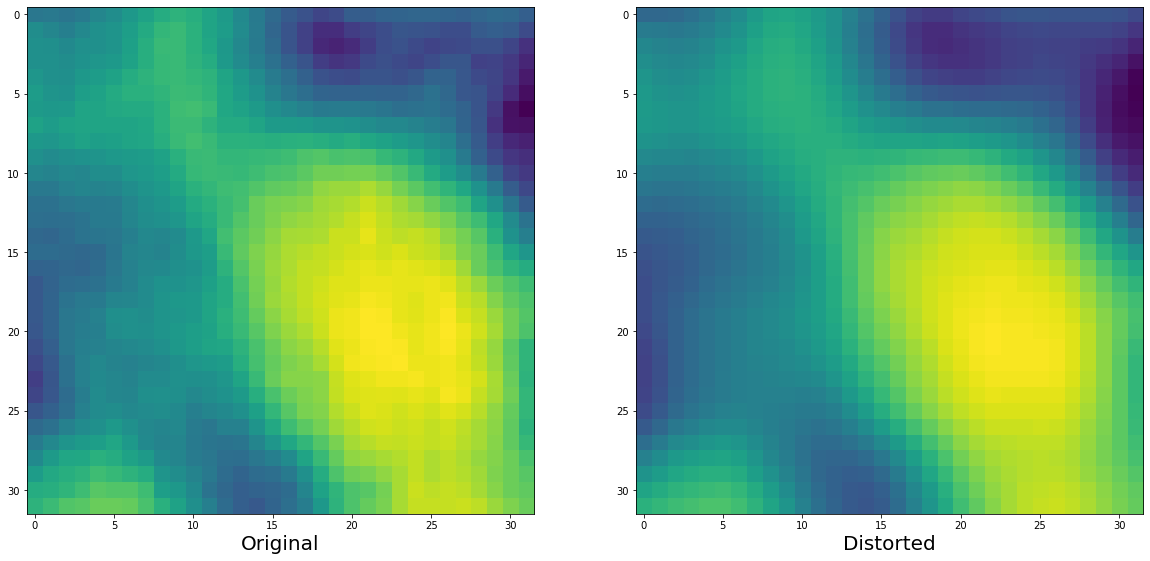

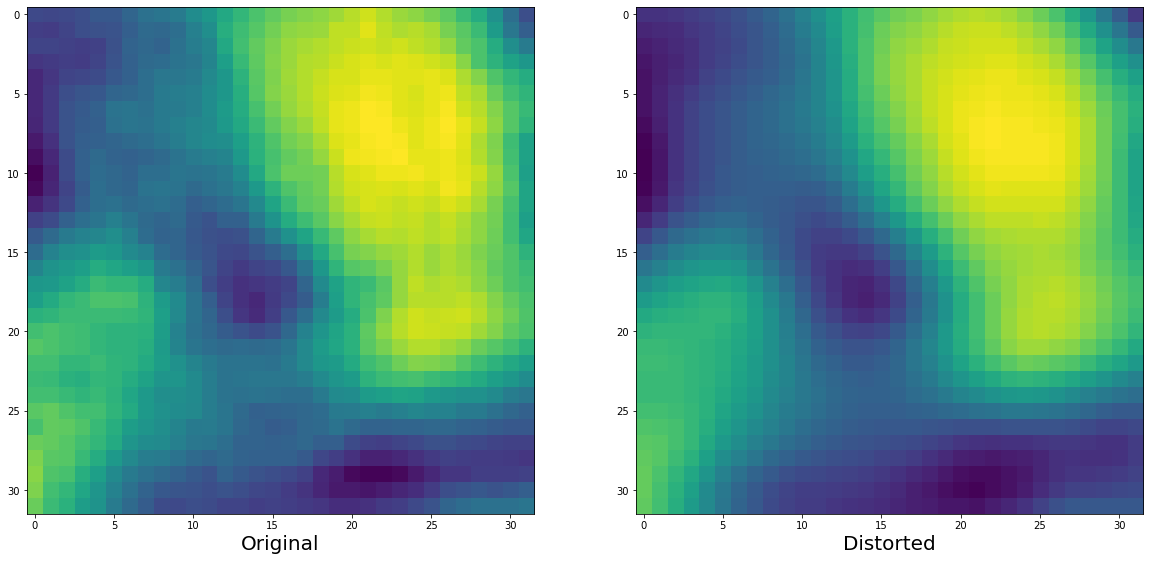

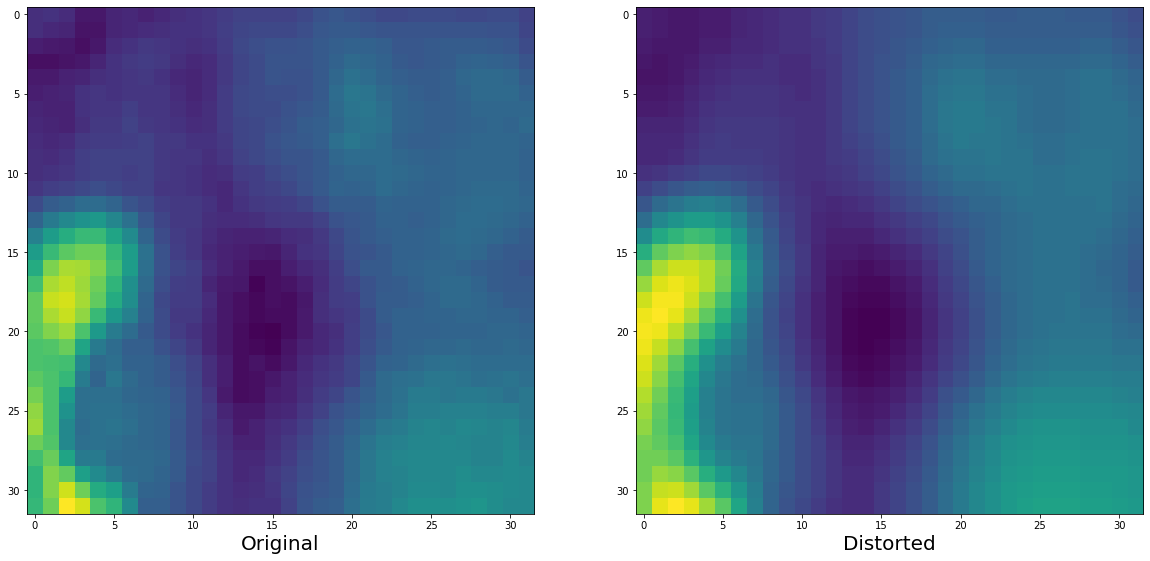

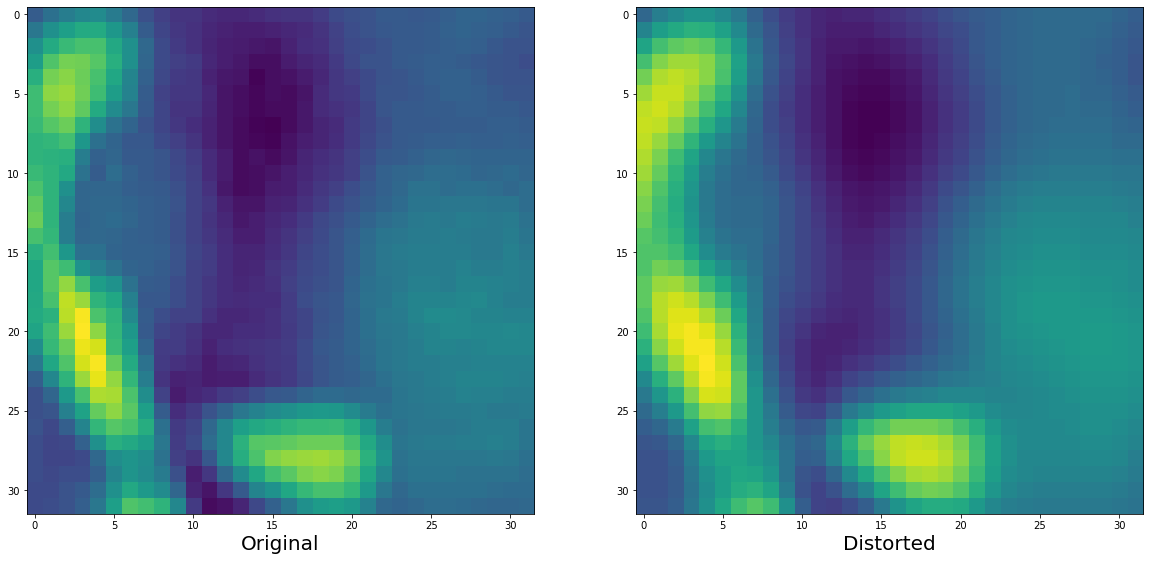

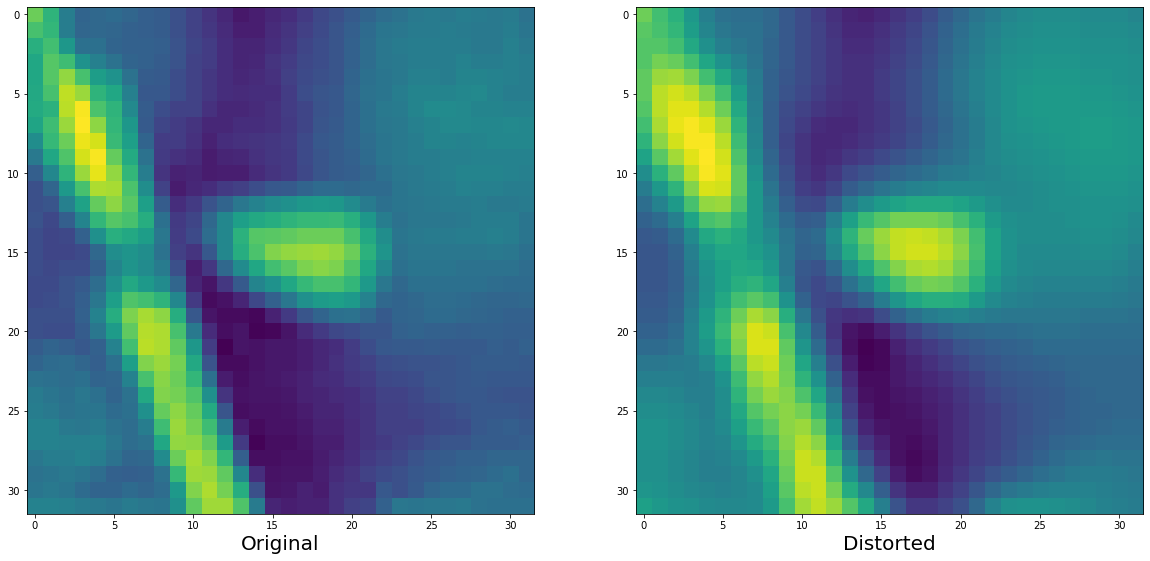

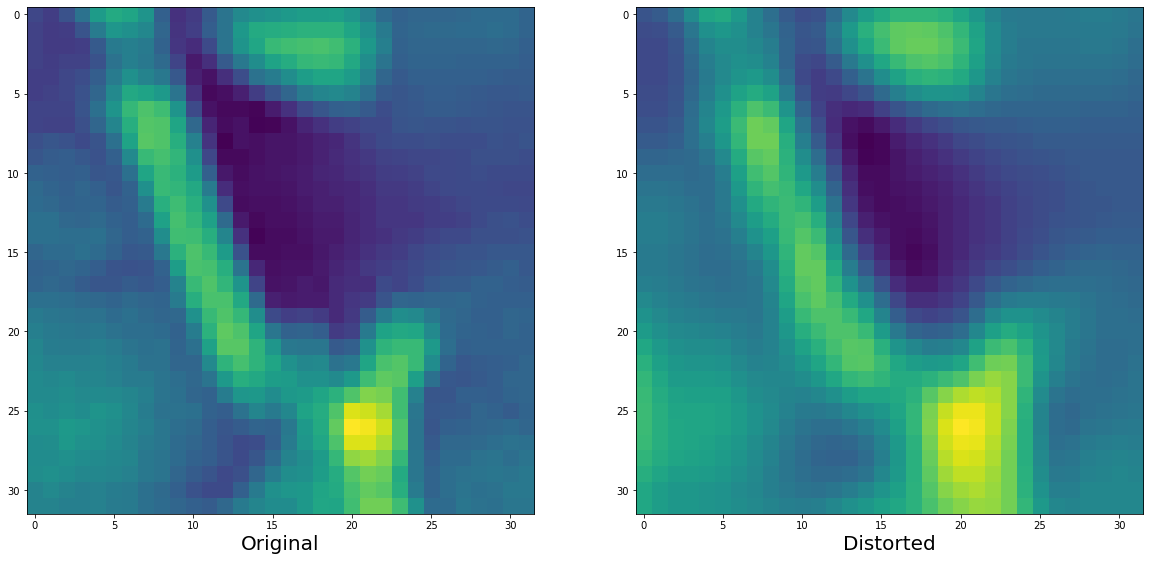

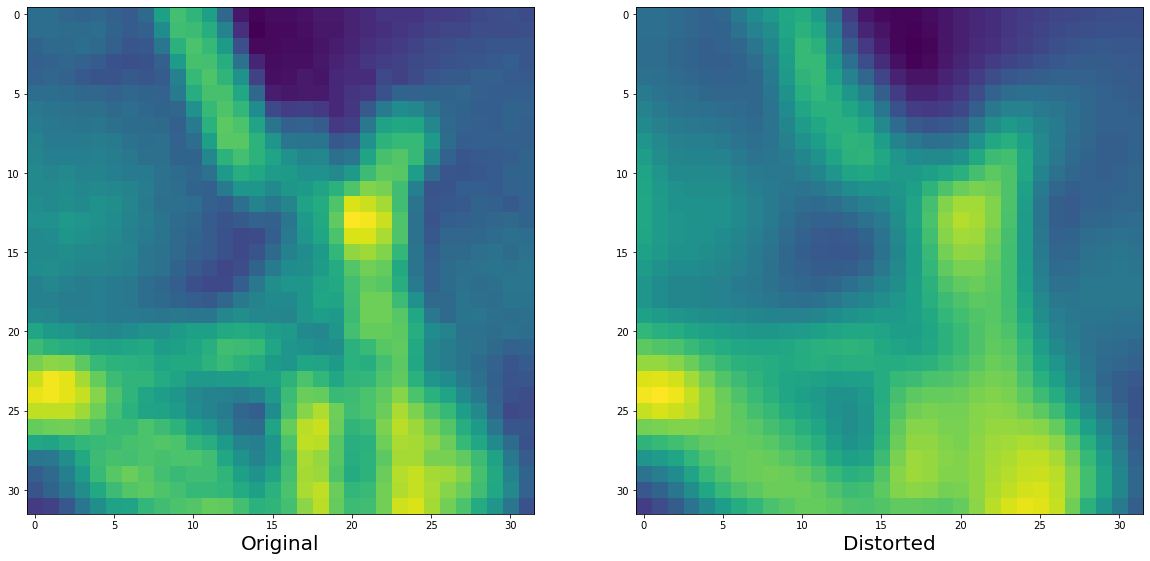

In [ ]:
# sanity check to make sure image distortions are reasonable
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))
    axarr[0].imshow(training_images_gt_patches[i])
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(training_images_training_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)

In [ ]:
aph = np.array(aph)
aph.shape

(0,)

In [ ]:
# prep input training images for use in dataset
training_images_training_patches = np.array(training_images_training_patches)
print(training_images_training_patches.shape)

training_images_training_patches /= 255.0
training_images_training_patches -= train_pixel_mean
training_images_training_patches /= train_pixel_std

training_images_training_patches = torch.tensor(training_images_training_patches)
training_images_gt_patches = torch.tensor(training_images_gt_patches)

training_images_training_patches.shape

(211600, 32, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


torch.Size([211600, 32, 32])

In [ ]:
my_training_dataset = data.TensorDataset(training_images_training_patches, training_images_gt_patches)
my_dataloader = data.DataLoader(my_training_dataset,
                                batch_size=128,
                                shuffle=True,
                                drop_last=True)    

In [ ]:
# generate validation set target images from BSDS500 val
val_img_names = [img for img in os.listdir('/content/BSR/BSDS500/data/images/val/') if img[-4:] == '.jpg']
val_images_gt_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('/content/BSR/BSDS500/data/images/val/'+img_name)
    im_val = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_val_Y = im_val[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_val_Y.shape[0]/8) * 8
    max_y = int(im_val_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_val_Y = im_val_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_val_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_val_Y.shape[0]-32, 13):
            sub_im = im_val_Y[j:j+32, i:i+32]
            val_images_gt_patches.append(sub_im)


In [ ]:
# prep target val images to be part of dataset

val_images_gt_patches = np.array(val_images_gt_patches)
print(val_images_gt_patches.shape)
#normalize
val_images_gt_patches /= 255.0
#standardize
val_images_gt_patches -= train_pixel_mean
val_images_gt_patches /= train_pixel_std

val_images_gt_patches = torch.tensor(val_images_gt_patches)
val_images_gt_patches.shape

(52900, 32, 32)


torch.Size([52900, 32, 32])

In [ ]:
# prep distorted validation input images 
val_images_val_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('/content/BSR/BSDS500/data/images/val/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='/content/BSR/BSDS500/data/images/val/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)

    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            val_images_val_patches.append(sub_im)

In [ ]:
# prep input val images to be part of dataset

val_images_val_patches = np.array(val_images_val_patches)
print(val_images_val_patches.shape)
#normalize
val_images_val_patches /= 255.0
#standardize
val_images_val_patches -= train_pixel_mean
val_images_val_patches /= train_pixel_std

val_images_val_patches = torch.tensor(val_images_val_patches)
val_images_val_patches.shape

(52900, 32, 32)


torch.Size([52900, 32, 32])

In [ ]:
my_val_dataset = data.TensorDataset(val_images_val_patches, val_images_gt_patches)
my_val_dataloader = data.DataLoader(my_val_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    drop_last=True)

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3)
        
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv1.bias)
        
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv2.bias)
        
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv3.bias)

    def forward(self, img):
        out = F.relu(self.conv1(img))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [ ]:
SR_model = SRCNN()
SR_model = SR_model.to(device)
print(SR_model.named_parameters)

criterion = torch.nn.MSELoss(reduction='mean').to(device)

optimizer = optim.SGD(
                      [
                          {"params": SR_model.conv1.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv2.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv3.parameters(), "lr": 0.00001},
                      ], momentum=0.9)

<bound method Module.named_parameters of SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)>


In [ ]:
best_val_loss = 10000.0
global_epoch = 0

In [ ]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

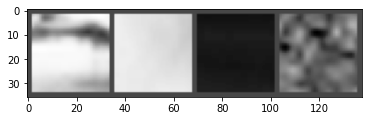

In [ ]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/SR_with_MSE_loss')
my_dataloader2 = data.DataLoader(my_training_dataset, batch_size=4, shuffle=True, drop_last=True)


        
# get some random training images
dataiter = iter(my_dataloader2)
images, labels = dataiter.next()


images_2 = torch.zeros((4,3,32,32))


images_2[:,0,:,:] = images
images_2[:,1,:,:] = images
images_2[:,2,:,:] = images


# create grid of images
img_grid = torchvision.utils.make_grid(images_2, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_training_images', img_grid)

writer.add_graph(SR_model, images.unsqueeze(1).float().to(device))
writer.close()


In [ ]:
def plot_images(img1, img2, img3):
  plt.subplot(231)
  plt.imshow(img1)
  plt.title('Ground Truth')
  plt.subplot(232)
  plt.imshow(img2)
  plt.title('Distorted')
  plt.subplot(233)
  plt.imshow(img3)
  plt.title('SR image')
  plt.subplot(234)
  plt.imshow(img1, cmap = 'gray')
  plt.subplot(235)
  plt.imshow(img2, cmap = 'gray')
  plt.subplot(236)
  plt.imshow(img3, cmap = 'gray')
  plt.show()
  

In [ ]:
# train for 15x10^6 back-props

for epoch in range(800-global_epoch):  # loop over the dataset multiple times
    print("epoch: ", global_epoch + 1)
    running_loss = 0.0
    for batch_i, data in enumerate(my_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ground_truth = data
        inputs = inputs.float().to(device)
        ground_truth = ground_truth.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = SR_model(inputs.unsqueeze(1))
        
        

        loss = criterion(outputs.squeeze(), ground_truth.float())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (global_epoch + 1, batch_i + 1, running_loss / 100))
            writer.add_scalar('training loss', running_loss / 100,
                              global_epoch * len(my_dataloader) + batch_i)
            running_loss = 0.0
    
    #end of epoch metric calculations         
    global_epoch += 1
    with torch.no_grad():

        val_loss = 0
        batch_i = 0
        for batch_i, data in enumerate(my_val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, ground_truth = data
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = SR_model(inputs.float().unsqueeze(1))

            

            val_loss += criterion(outputs.squeeze(), ground_truth.float())
        
        #get average loss per batch, to match how loss is reported in training
        val_loss = val_loss/(len(my_val_dataloader))
        writer.add_scalar('validation loss', val_loss, global_epoch)
        
        print('epoch %d validation loss: %f'%(global_epoch, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            print("New lowest loss found. Saving checkpoint.")
            torch.save({'epoch': global_epoch,
                        'model_state_dict': SR_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val loss': val_loss
                        }, './checkpoint_SRCNN_w_MSE.pt')
        # eval over a unrelated dataset to track psnr
        
        mean_blur_psnr, mean_sr_psnr = evaluate_model(path='/content/gdrive/MyDrive/mytestset/', 
                                                      model=SR_model, 
                                                      pixel_mean=train_pixel_mean, 
                                                      pixel_std=train_pixel_std)
        print(os.listdir())
        #note: evaluate_model was called when the default arg in the module
        # was 4 for SR_FACTOR. It is set to three now, and in the FDPL run
        writer.add_scalars('Test5 PSNR (dB)', {'bicubic_psnr':mean_blur_psnr,
                                               'srcnn_psnr':mean_sr_psnr}, global_epoch)
        print("test5: bicubic = %f; srcnn = %f"%(mean_blur_psnr, mean_sr_psnr))
            
            
print('Finished Training')

epoch:  3
[3,   100] loss: 1.003
[3,   200] loss: 1.016
[3,   300] loss: 1.001
[3,   400] loss: 1.001
[3,   500] loss: 0.986
[3,   600] loss: 0.988
[3,   700] loss: 0.997
[3,   800] loss: 1.003
[3,   900] loss: 1.005
[3,  1000] loss: 1.000
[3,  1100] loss: 0.999
[3,  1200] loss: 0.995
[3,  1300] loss: 0.993
[3,  1400] loss: 0.990
[3,  1500] loss: 1.002
[3,  1600] loss: 1.010
epoch 3 validation loss: 1.031506
New lowest loss found. Saving checkpoint.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


The bicubic psnr of 1 image is 40.106112149955855. The blur ssim is 0.9779588179515948 and the blur fsim is 0.7338329085837393


The sr psnr of 1 image is 10.604320035367763. The blur ssim is 0.757108747410262 and the blur fsim is 0.36727503396818423
The bicubic psnr of 2 image is 36.63572283476568. The blur ssim is 0.9446519177975389 and the blur fsim is 0.5857401962720298


The sr psnr of 2 image is 10.792662957052844. The blur ssim is 0.4201758543991911 and the blur fsim is 0.3954388962569259


KeyboardInterrupt: ignored

In [ ]:
# generate distorted images for training, using train and test of BSDS500
test_imgs = [i for i in os.listdir('/content/gdrive/MyDrive/Data/mytestset/') if i[-4:] == '.jpg']
test_patches = []
for idx, img_name in enumerate(test_imgs):
    ImageFile = Image.open('/content/gdrive/MyDrive/Data/mytestset/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]   
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='/content/gdrive/MyDrive/Data/mytestset/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            test_patches.append(sub_im)

# training_img_names = [i for i in os.listdir('/content/BSR/BSDS500/data/images/test/') if i[-4:] == '.jpg']
# for idx, img_name in enumerate(training_img_names):
#     ImageFile = Image.open('/content/BSR/BSDS500/data/images/test/'+img_name)
#     im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
#     im_train_Y = im_train[:,:,0]
#     #crop image to be multiple of 8 in both dims
#     max_x = int(im_train_Y.shape[0]/8) * 8
#     max_y = int(im_train_Y.shape[1]/8) * 8
#     square_dim = min(max_x, max_y)
#     im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
#     im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
#     im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

#     # distort image with blur, downsize and upsize bicubic interpolation
#     im_Y_blur = distort_image(path='/content/BSR/BSDS500/data/images/test/'+img_name, 
#                               factor=SR_FACTOR, 
#                               sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
#     for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
#         for j in range(0, im_Y_blur.shape[0]-32, 13):
#             sub_im = im_Y_blur[j:j+32, i:i+32]
#             training_images_training_patches.append(sub_im)
# sanity check to make sure image distortions are reasonable



In [ ]:
print(len(test_imgs))

5


In [ ]:
print(len(test_patches))  

11213


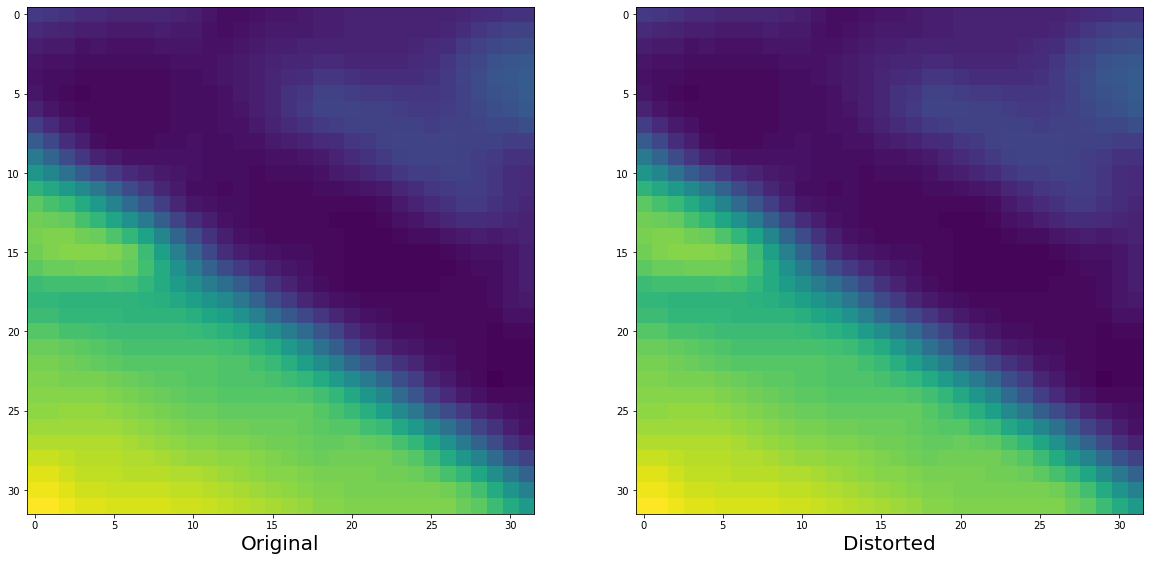

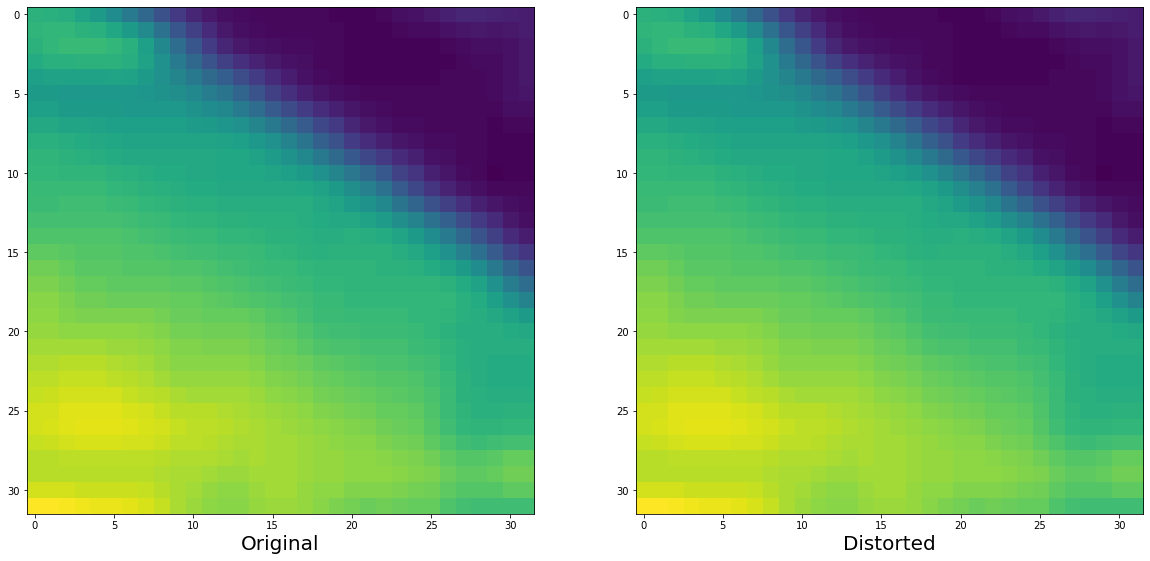

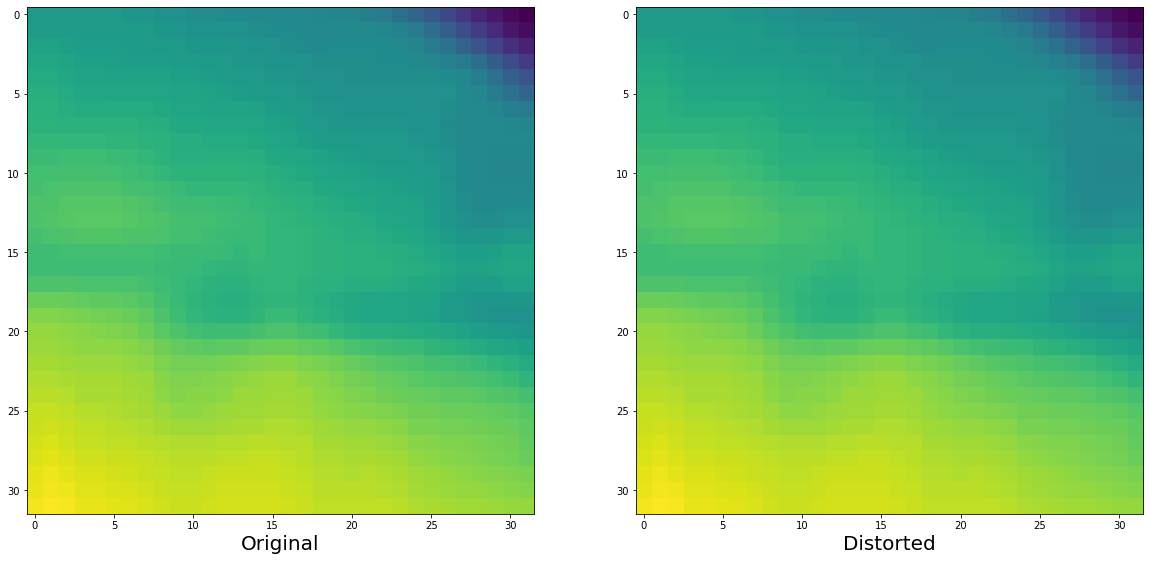

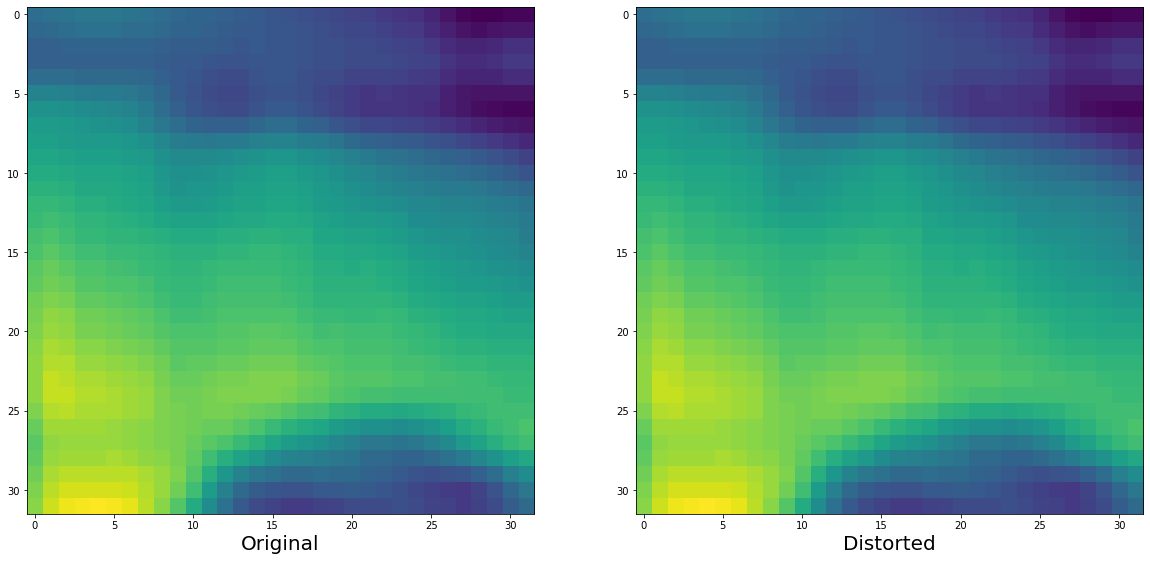

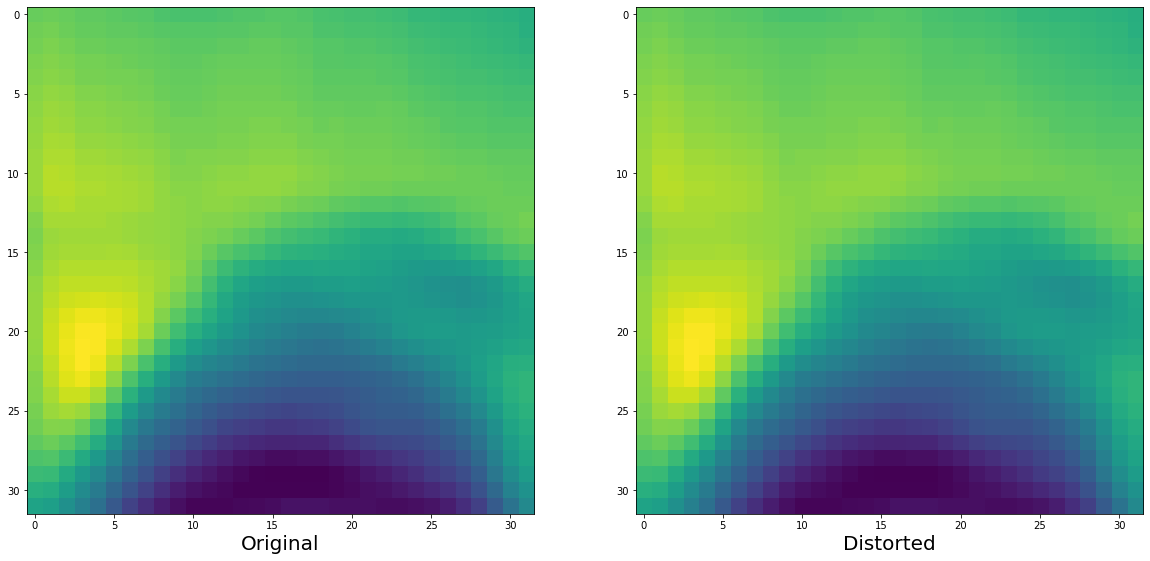

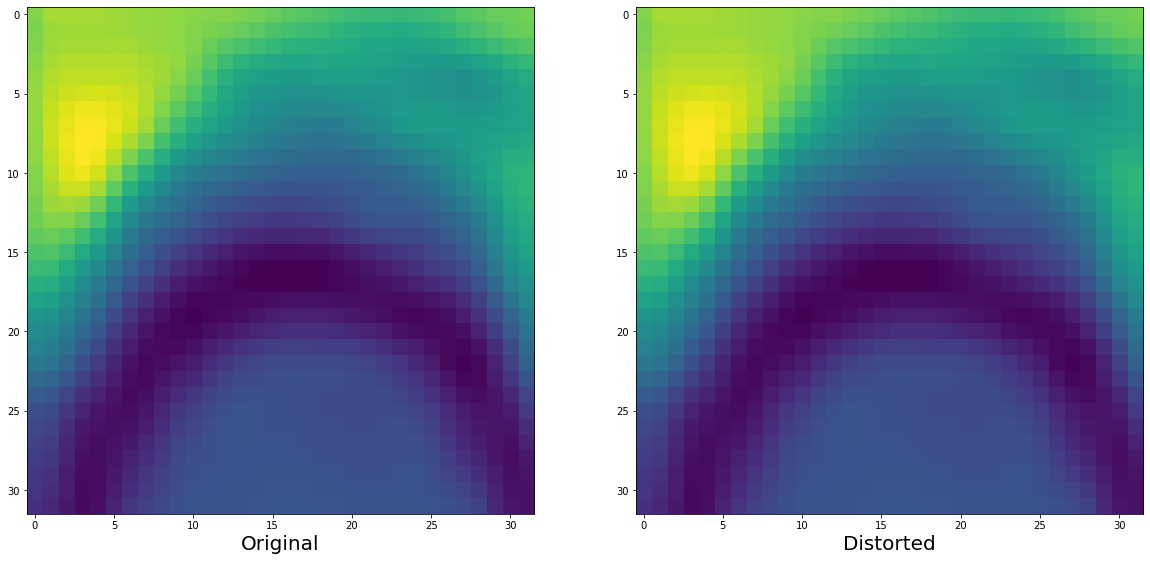

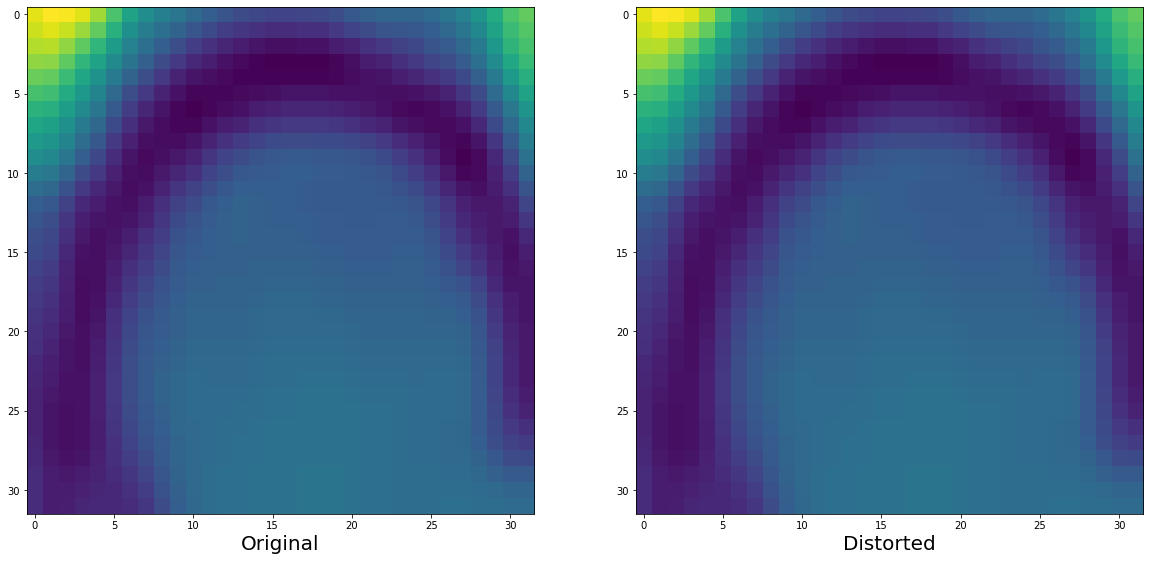

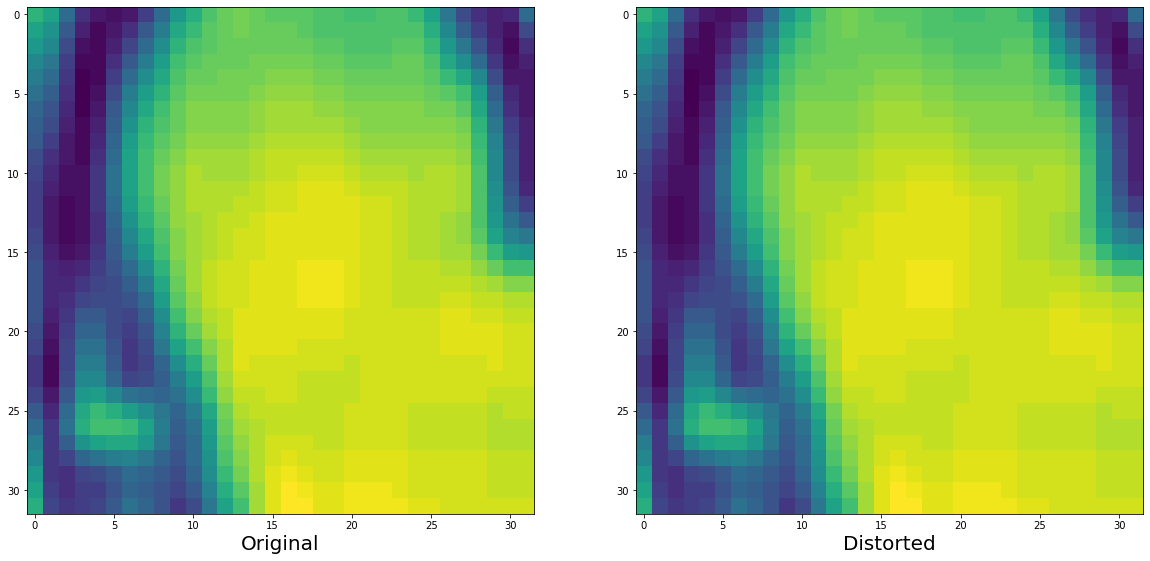

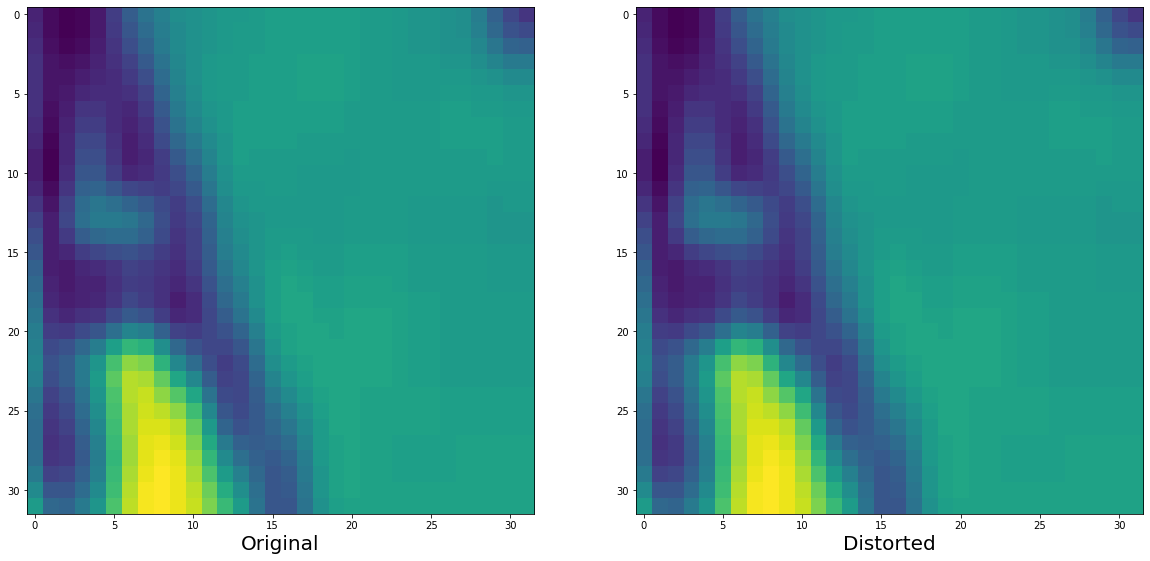

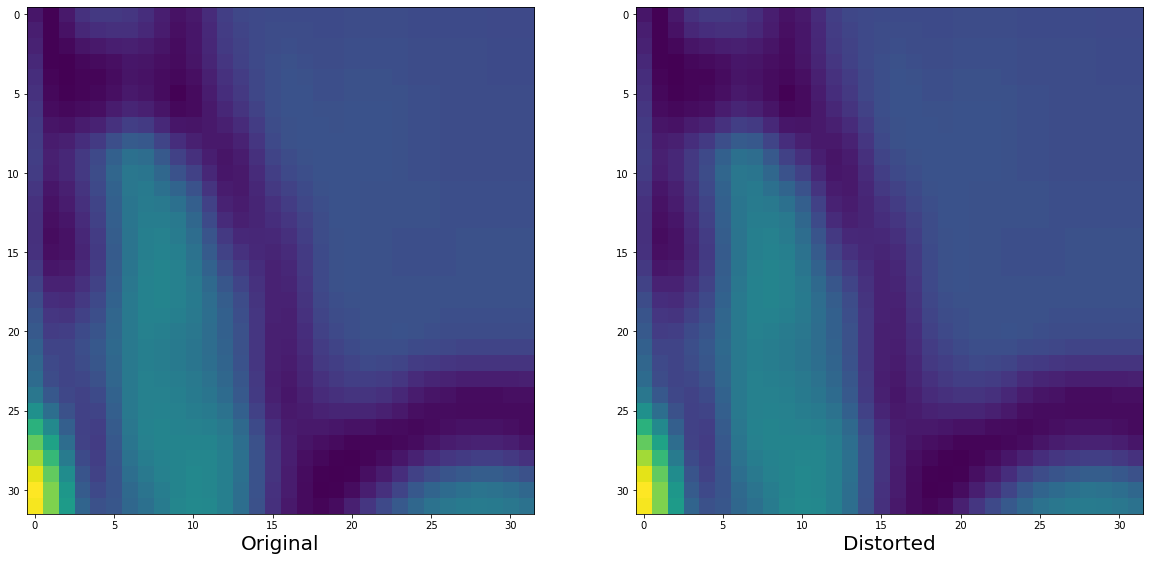

In [ ]:
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))
    axarr[0].imshow(test_patches[i])   
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(test_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)

In [ ]:
#200 EPOCHS = 32.219512 db
#500 EPOCHS = 32.314365

### Median

In [ ]:
import cv2

In [ ]:

def distort_image_new(path, factor, sigma=1, blur=True):
  """ Distorts image by bluring it, decreasing its resolution
      by some factor, then increasing resolution - by bicubic
      interpolation.
      Args:
          path (string): absolute path to an image file
          factor (int): the resolution factor for interpolation
          sigma (float): the std. dev. to use for the gaussian blur
          blur (boolean): if True, gaussian blur is performed on im
      Returns:
          blurred_img (numpy.ndarray): distorted image in YCbCr with
              type uint8
  """
  image_file = Image.open(path)
  im = np.array(image_file.convert('YCbCr'))
  im_Y, im_Cb, im_Cr = im[:, :, 0], im[:, :, 1], im[:, :, 2]
  im_Y = (im_Y.astype(np.int16)).astype(np.int64)
  im_Cb = (im_Cb.astype(np.int16)).astype(np.int64)
  im_Cr = (im_Cr.astype(np.int16)).astype(np.int64)
  if blur:
      im_Y_blurred = cv2.blur(im_Y, (5,5))
  else:
      im_Y_blurred = im_Y
  im_blurred = np.copy(im)
  im_blurred[:, :, 0] = im_Y_blurred
  im_blurred[:, :, 1] = im_Cb
  im_blurred[:, :, 2] = im_Cr
  width, length = im_Y.shape
  im_blurred = Image.fromarray(im_blurred, mode='YCbCr')
  im_blurred = im_blurred.resize(size=(int(length/factor),
                                        int(width/factor)),
                                  resample=Image.BICUBIC)

  im_blurred = im_blurred.resize(size=(length, width),
                                  resample=Image.BICUBIC)
  im_blurred = np.array(im_blurred.convert('YCbCr'))
  return im_blurred